# Summary

This notebook contains the full experimental evaluation of MaNIACS on the datasets described in Table 2 of the paper.

For each dataset, we report:
1. the running time of the exact version of MaNIACS
2. the running time of MaNIACS using different sample sizes
3. the number of patterns found by MaNIACS vs the actual number of frequent patterns
4. the accuracy of the output of MaNIACS in terms of the evaluation metrics described in Section 5 of the paper
5. the comparison between the theoretical upper bounds to the maximum estimation error and the actual maximum error
6. the scalability of MaNIACS varying frequency threshold

# Libraries

In [611]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [612]:
import matplotlib

Chart Styling

In [613]:
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.weight'] = 'bold'
matplotlib.rcParams['axes.labelweight'] = 'bold'
matplotlib.rcParams['axes.spines.top'] = 'False'
matplotlib.rcParams['axes.spines.right'] = 'False'
matplotlib.rcParams['axes.spines.left'] = 'False'
matplotlib.rcParams['axes.spines.bottom'] = 'False'
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['axes.grid.axis'] = 'y'
matplotlib.rcParams['axes.titleweight'] = 'bold'
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20 
matplotlib.rcParams['legend.markerscale'] = 2
matplotlib.rcParams['legend.fontsize'] = 18 
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

In [614]:
palette = sns.color_palette(["#1D1128", "#EF946C", "#065A82","#66101F", "#7FD1B9"])

In [615]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr, kendalltau

# Methods

In [658]:
def computeMAE(exact, approx):
    if len(exact) == 0: 
        return 0.0
    if len(approx) == 0:
        return 1.0
    cum_sum = sum(np.array([abs(exact[x] - approx[x]) for x in approx if x in exact]))
    return (1. / len(approx)) * cum_sum

In [659]:
def computeME(exact, approx):
    if len(exact) == 0:
        return (0.0, -1)
    if len(approx) == 0:
        return (1.0, 0)
    tmp = np.array([(abs(exact[x] - approx[x]), len(x.split("-")[0].split(" "))) for x in approx if x in exact])
    tmp = sorted(tmp, key=lambda x: -x[0])
    return tmp[0]

In [660]:
def computePrecision(exact, approx):
    if len(approx) == 0:
        return 1.0
    if len(exact) == 0:
        return 0.0
    return 1. * len([x for x in approx if x in exact]) / len(approx)

In [661]:
def computeRecall(exact, approx):
    if len(exact) == 0:
        return 1.0
    if len(approx) == 0:
        return 0.0
    return 1. * len([x for x in approx if x in exact]) / len(exact)

In [662]:
def computeF1(exact, approx):
    prec = computePrecision(exact, approx)
    rec = computeRecall(exact, approx)
    if prec == 0.0:
        return 0.0
    return 2 * prec * rec / (prec + rec)

In [663]:
def computeRankCorrelations(exact, approx):
    if len(exact) == 0 and len(approx) == 0:
        return (1.0,1.0)
    if len(exact) == 0 or len(approx) == 0:
        return (0.0,0.0)
    
    size = min(len(exact), len(approx))
    exact_freqs = []
    approx_freqs = []
    
    tmp = sorted(approx.items(), key=lambda x: -x[1])
    for i in range(size):
        approx_freqs.append(tmp[i][1])
        exact_f = 0
        if tmp[i][0] in exact: 
            exact_f = exact[tmp[i][0]]
        exact_freqs.append(exact_f)
    return (spearmanr(exact_freqs, approx_freqs)[0], kendalltau(exact_freqs, approx_freqs)[0])

In [664]:
 def load_patterns(f):
    patterns = {}
    epsilons = []
    with open(f) as in_f:
        for line in in_f.readlines():
            if line:
                lst = line.split("\t")
                if len(lst) == 1:
                    epsilons.append(float(lst[0]))
                else:
                    freq = float(lst[0])
                    patterns[lst[1].strip() + "-" + lst[2].strip()] = freq
    while len(epsilons) < 4:
        epsilons.append(0)
    return (patterns, np.array(epsilons))

# Data Folder

In [665]:
data_dir = '/output/'

In [666]:
seeds = [1, 3, 5, 7, 11]

# Load Statistics File

In [667]:
stats = pd.read_csv(data_dir + 'statistics.csv', sep='\t', header=None, names=['dataset','timestamp', 'time', 'freq_patterns', 'tau', 'max_size', 'is_pregenerated', 'sample_size', 'seed'])
stats.drop(['timestamp', 'seed', 'is_pregenerated', 'max_size'], axis=1, inplace=True)
stats

,dataset,time,freq_patterns,tau,sample_size
0,mico.lg,0.239,0,0.25,EX
1,mico.lg,1.130,1,0.20,EX
2,mico.lg,11.573,2,0.18,EX
3,mico.lg,24.643,2,0.16,EX
4,mico.lg,31.275,3,0.14,EX
...,...,...,...,...,...
1648,youtube.lg,304.272,33,0.08,90000
1649,youtube.lg,346.480,33,0.08,120000
1650,youtube.lg,503.694,28,0.08,240000
1651,youtube.lg,869.071,25,0.08,600000


## Aggregate Data per Dataset

In [668]:
datasets = stats['dataset'].unique()
stats_d = {}
stats_ex_d = {}
sample_sizes_d = {}
freqs_d = {}

In [669]:
for d in datasets:
    tmp = stats.loc[stats['dataset']==d]
    tmp.drop(['dataset'], axis=1, inplace=True)
    tmp1 = tmp[tmp['sample_size'] != "EX"]
    tmp1 = tmp1.groupby(by=['tau', 'sample_size']).mean().reset_index()
    tmp1 = tmp1.astype({'sample_size': 'int32'})
    stats_d[d] = tmp1
    tmp2 = tmp[tmp['sample_size'] == "EX"]
    tmp2.drop(['sample_size'], axis=1, inplace=True)
    tmp2 = tmp2.groupby(by=['tau']).mean().reset_index()
    stats_ex_d[d] = tmp2

/Users/giulia/.pyenv/versions/3.7.2/envs/notebook_env/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [670]:
for d in datasets:
    sample_sizes_d[d] = sorted(stats_d[d]['sample_size'].unique())
    freqs_d[d] = sorted(stats_d[d]['tau'].unique())

Renaming and selection of data to plot

In [671]:
sizes_to_plot = {}
sizes_to_plot['citeseer.lg'] = [1000,1400,2000,2600]
sizes_to_plot['phy_citations_grouped.lg'] = [9000,15000,18000,21000]
sizes_to_plot['patents_decade.lg'] = [9000,12000,18000,30000]
sizes_to_plot['mico.lg'] = [6000,9000,18000,48000]
sizes_to_plot['youtube.lg'] = [60000, 120000, 240000, 600000]

In [672]:
sample_sizes_d_names = {}
sample_sizes_d_names['mico.lg'] = ['6K', '9K', '18K', '48K']
sample_sizes_d_names['phy_citations_grouped.lg'] = ['6K', '9K', '12K', '15K', '18K', '21K']
sample_sizes_d_names['patents_decade.lg'] = ['6K', '9K', '12K', '18K', '30K']
sample_sizes_d_names['citeseer.lg'] = ['1K', '1.4K', '1.7K', '2K', '2.3K', '2.6K', '2.9K']
sample_sizes_d_names['youtube.lg'] = ['9K', '12K', '24K', '60K', '90K', '120K', '240K', '600K', '900K', '1.2M']

In [673]:
freqs_to_plot = {}
freqs_to_plot['citeseer.lg'] = [0.09,0.12,0.14,0.16,0.18,0.20]
freqs_to_plot['phy_citations_grouped.lg'] = [0.17,0.18,0.20,0.21,0.23,0.25]
freqs_to_plot['patents_decade.lg'] = [0.17,0.18,0.20,0.21,0.23,0.27]
freqs_to_plot['mico.lg'] = [0.09,0.12,0.14,0.16,0.18,0.20]
freqs_to_plot['youtube.lg'] = [0.09, 0.1, 0.11, 0.12, 0.13, 0.15]

## Time Statistics

mico.lg


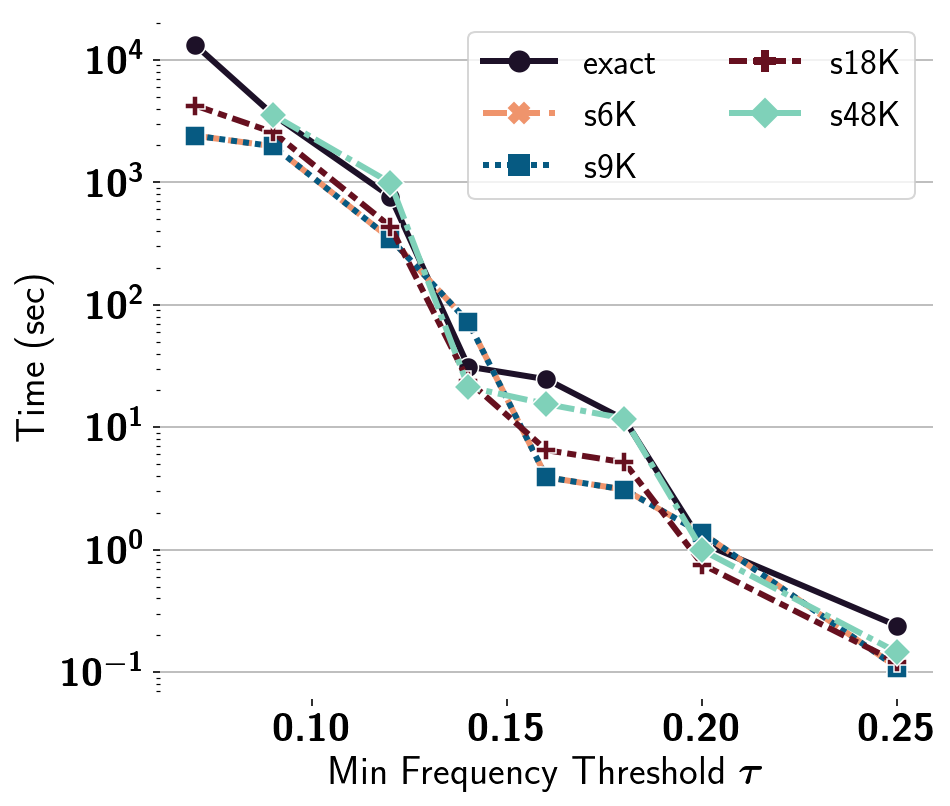

youtube.lg


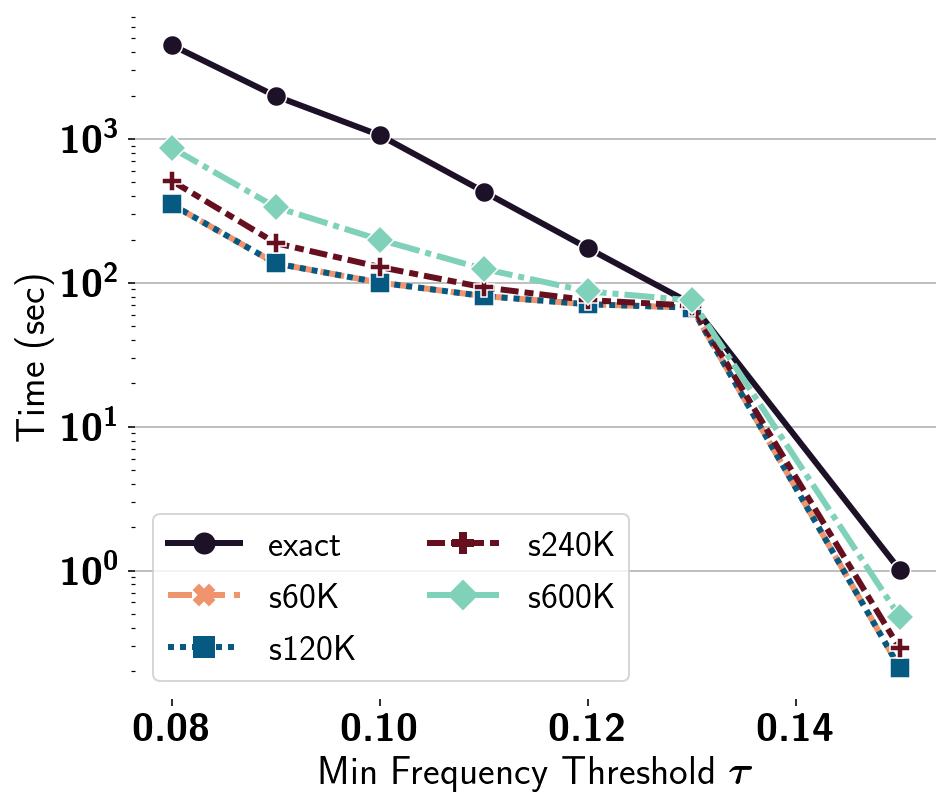

citeseer.lg


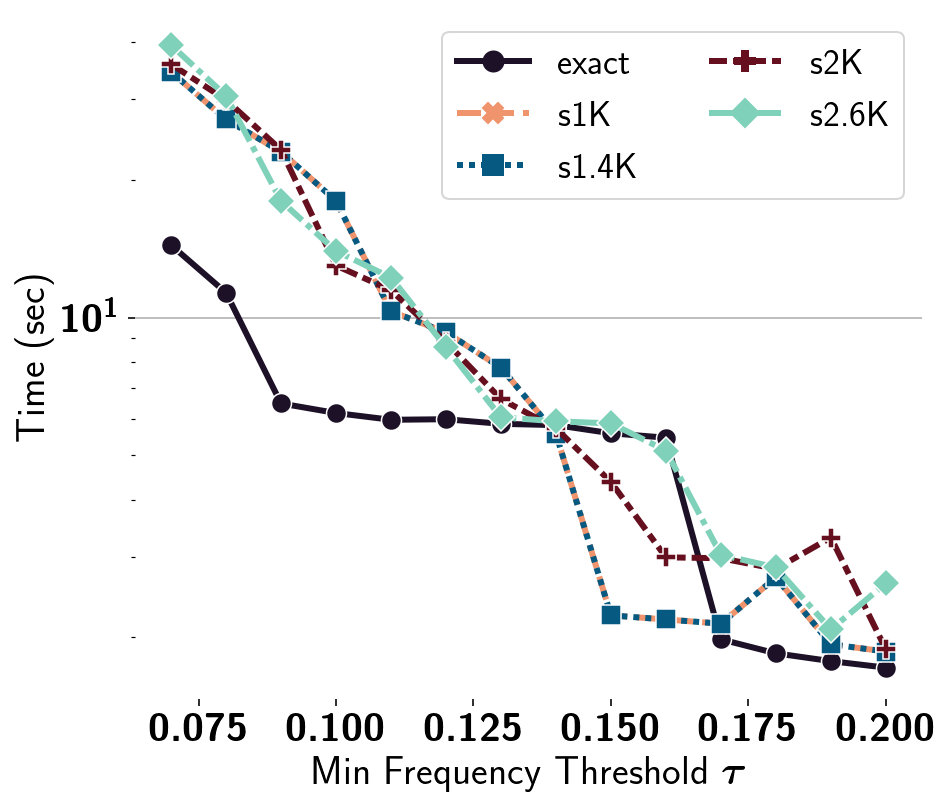

phy_citations_grouped.lg


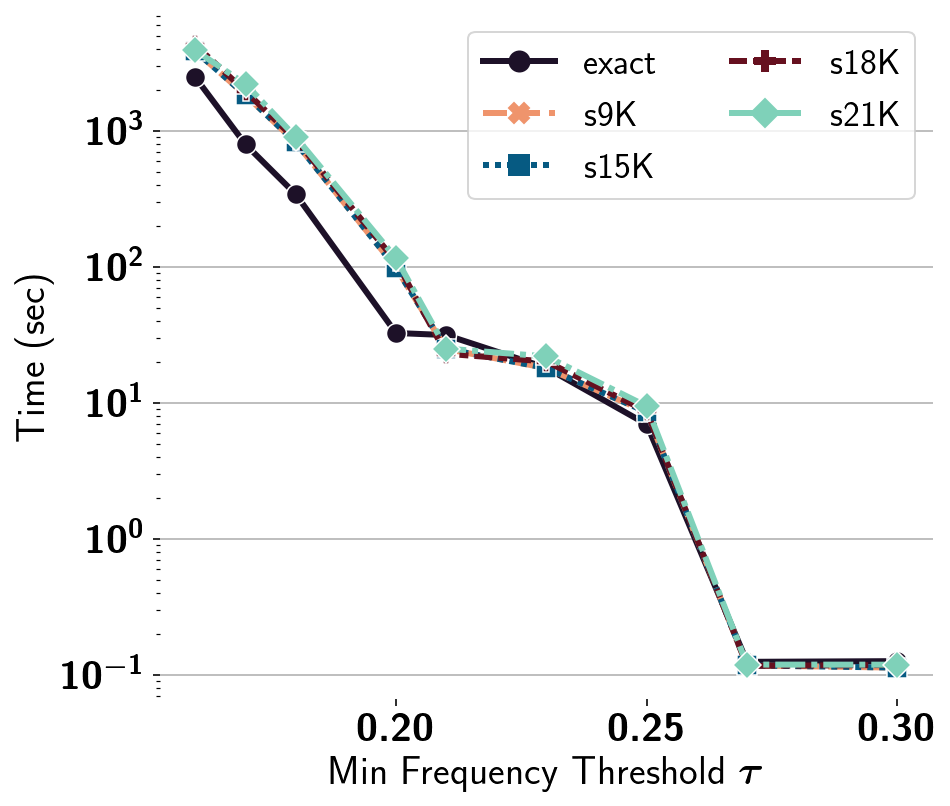

patents_decade.lg


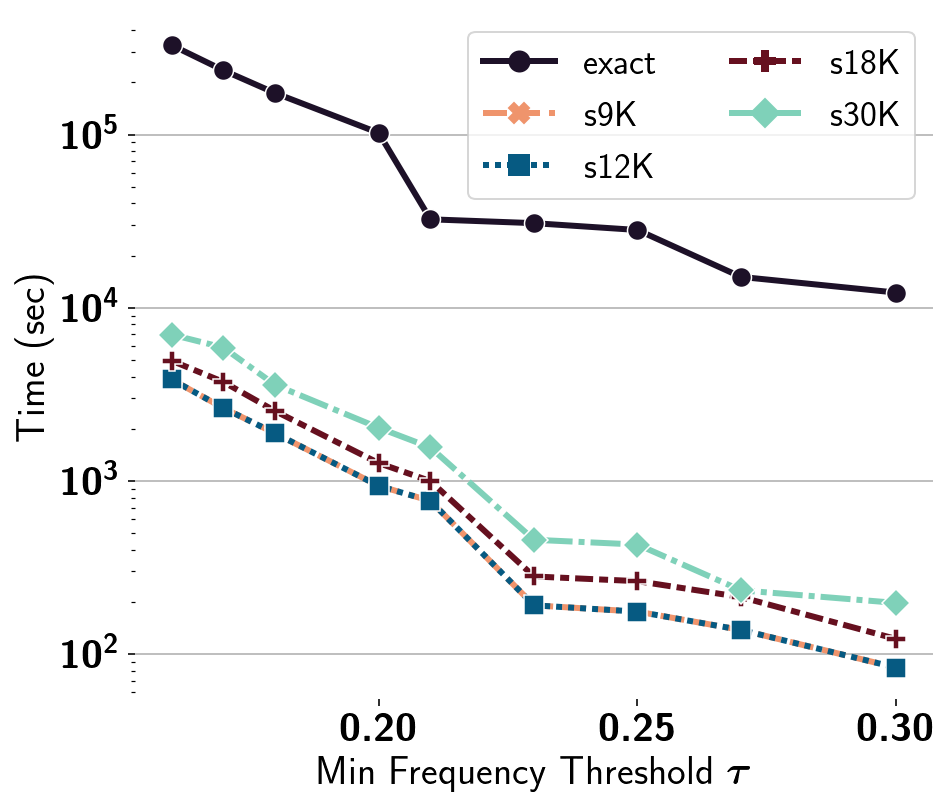

In [677]:
for d in datasets:
    print(d)
    plt.figure(figsize=(7,6))
    # prepare data
    data = stats_d[d][stats_d[d]['sample_size']==sizes_to_plot[d][1]].set_index('tau')[['time']]
    data.rename(columns={'time' : str(sizes_to_plot[d][0])}, inplace=True)
    for s in sizes_to_plot[d][1:]:
        data[str(s)] = stats_d[d][stats_d[d]['sample_size']==s].set_index('tau')[['time']]
    data['exact'] = stats_ex_d[d].set_index('tau')['time']
    columns = [data.columns[-1]]
    columns.extend(data.columns[:-1].values)
    data = data[columns]
    for c in data.columns[1:]:
        name = int(c)/1000
        if name == int(name):
            name = int(name)
        data.rename(columns={c:f's{name}K'}, inplace=True)
    # plot
    sns.lineplot(data=data, palette=palette, linewidth=3, markers=True, markersize=10)
    # style 
    plt.ylabel('Time (sec)')
    plt.yscale('log')
    plt.grid(axis='y')
    plt.xlabel(r'Min Frequency Threshold $\tau$')
    # legend
    legend = plt.gca().legend(ncol=2)
    for line in legend.get_lines():
        line.set_linewidth(3)
    for marker in legend.legendHandles:
        marker._legmarker.set_markersize(10)
    plt.tight_layout()
    plt.savefig(f'runtime_{d}.pdf', bbox_inches='tight')

    plt.show()

## Number of Frequent Patterns Found

mico.lg


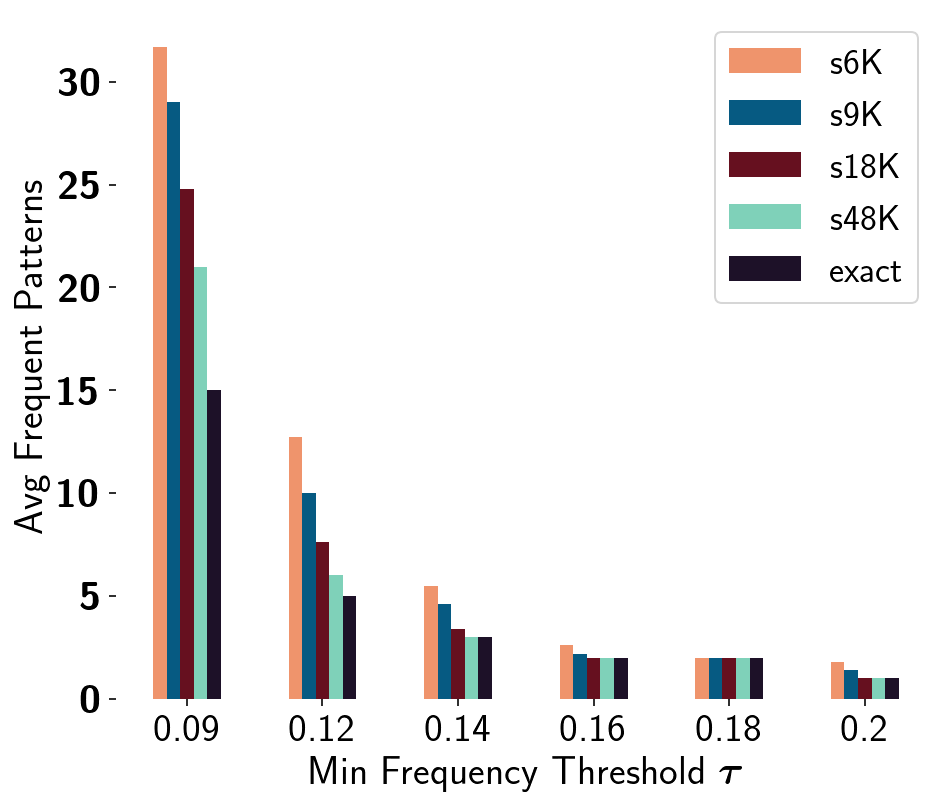

youtube.lg


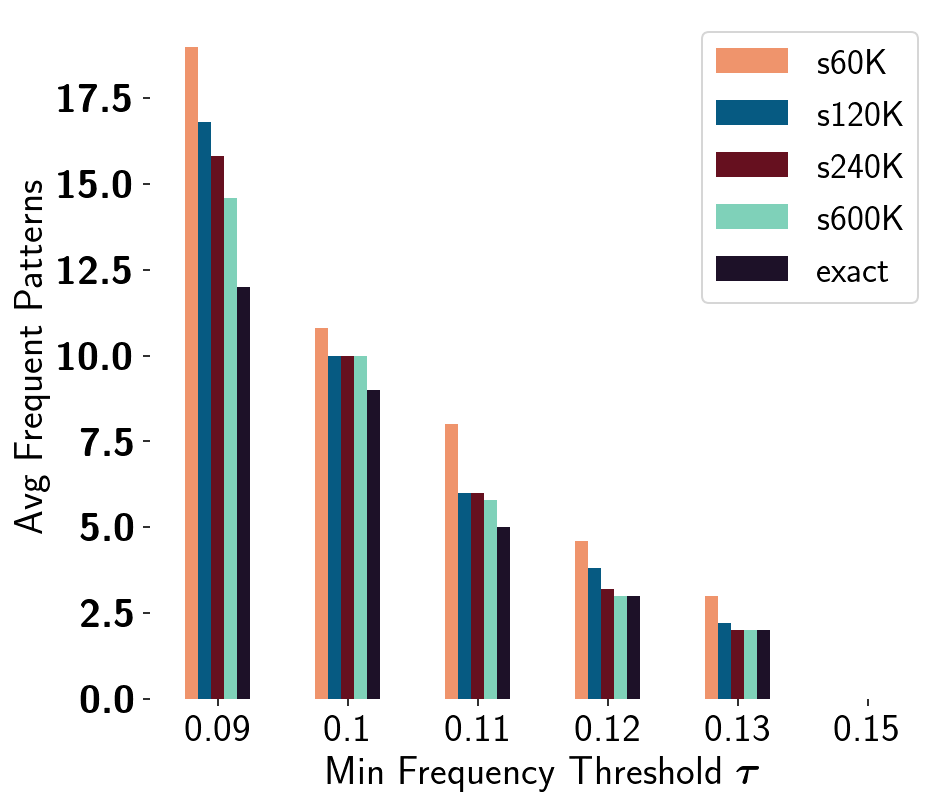

citeseer.lg


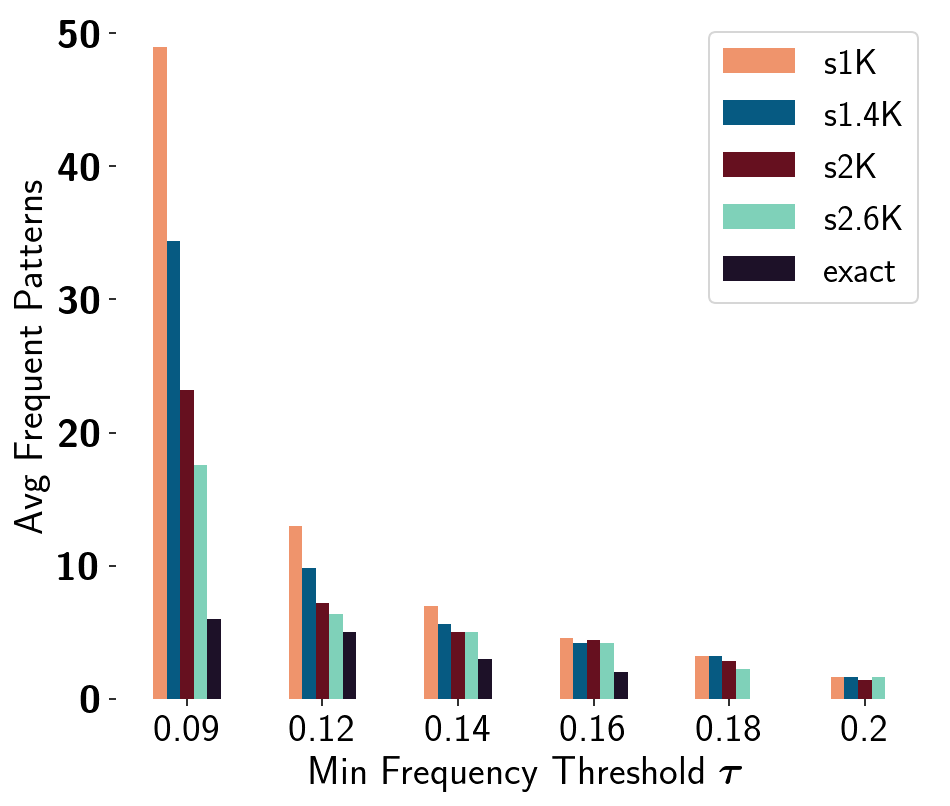

phy_citations_grouped.lg


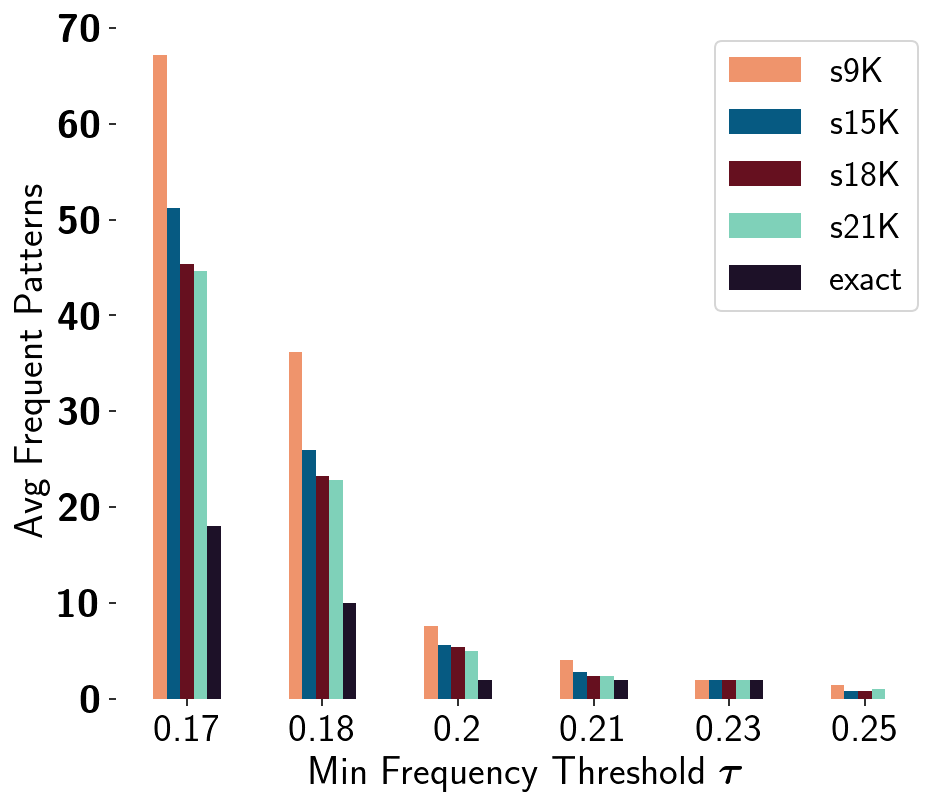

patents_decade.lg


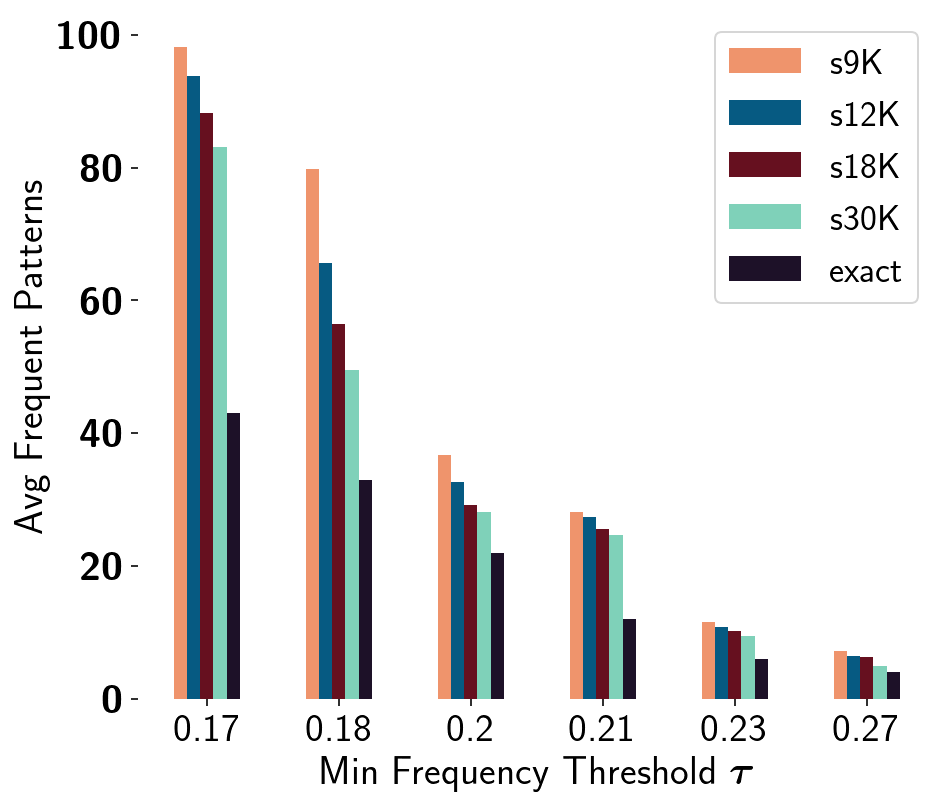

In [678]:
for d in datasets:
    plt.figure(figsize=(7,6))
    # prepare data
    width = 10
    x = np.arange(6) * 100
    n = len(sizes_to_plot[d]) + 1
    for i,s in enumerate(sizes_to_plot[d]):
        l = stats_d[d][stats_d[d]['sample_size']==s].set_index('tau')
        bars = []
        for f in freqs_to_plot[d]:
            if f in l['freq_patterns']:
                bars.append(l['freq_patterns'][f])
            else:
                bars.append(0)
        label = int(s)/1000
        if label == int(label):
            label = int(label)
        plt.bar(x - (n/2)*width+width*i, bars, width=width, label=f's{label}K', align='edge', color=palette[i+1])
    # exact algorithm
    exact = stats_ex_d[d].set_index('tau')
    bars = []
    for f in freqs_to_plot[d]:
        if f in exact['freq_patterns']:
            bars.append(exact['freq_patterns'][f])
        else:
            bars.append(0)
    plt.bar(x + (n/2)*width - width, bars, width=width, color=palette[0], label='exact', align='edge')
    # style
    plt.ylabel('Avg Frequent Patterns')
    plt.xlabel(r'Min Frequency Threshold $\tau$')
    plt.xticks(x, freqs_to_plot[d], fontweight='bold')
    # legend
    for line in plt.legend().get_lines():
        line.set_linewidth(3.0)

    plt.tight_layout()
    plt.savefig(f'avg_patterns_{d}.pdf', bbox_inches='tight')
    print(d)
    plt.show()

# Load Pattern Files

In [679]:
patterns_stats_m = []

In [680]:
for d in datasets:
    for freq in freqs_d[d]:
        if d in {'mico.lg', 'youtube.lg'}:
            exact_file = f"MANIAC_{d}_F{freq}P5FEX0"
        else:
            exact_file = f"MANIAC_{d}_F{freq}P5TEX0"
        try:
            pa = load_patterns(data_dir + exact_file)
            exact = pa[0]
        except:
            continue
        for sample in sample_sizes_d[d]:
            mae = me = f1 = spearman = kendall = div = pr = re = 0
            me_loc = []
            avgeps = np.zeros(4)
            for seed in seeds:
                if d == 'mico.lg':
                    approx_file = f"MANIAC_{d}_F{freq}P5FAX{sample}S{seed}"
                else:
                    approx_file = f"MANIAC_{d}_F{freq}P5TAX{sample}S{seed}"
                try:
                    pa = load_patterns(data_dir + approx_file)
                    approx = pa[0]
                    if len(pa[1]) > 4:
                        avgeps += pa[1][1:]
                    else:
                        avgeps += pa[1]
                    div += 1
                except:
                    continue
                me_p = computeME(exact, approx)
                me += me_p[0]
                me_loc.append(me_p[1])
                mae += computeMAE(exact, approx)
                f1 += computeF1(exact, approx)
                pr += computePrecision(exact, approx)
                re += computeRecall(exact, approx)
                if len(approx) > 1:
                    corr = computeRankCorrelations(exact, approx)
                    spearman += corr[0]
                    kendall += corr[1]
            if div > 0:
                runtime = stats_d[d][(stats_d[d]['tau']==freq) & (stats_d[d]['sample_size']==sample)]['time'].values[0]
                try:
                    runtime_exact = stats_ex_d[d][(stats_ex_d[d]['tau']==freq)]['time'].values[0]
                except:
                    runtime_exact = 1.
                patterns_stats_m.append([d, freq, sample, "{:.3f} ({:.3f})".format(runtime,(runtime/runtime_exact)), me/div, mae/div, pr/div, re/div, f1/div, spearman/div, kendall/div, 
                 avgeps[0]/div, avgeps[1]/div, avgeps[2]/div, avgeps[3]/div])

## Accuracy

In [681]:
patterns_stats = pd.DataFrame(patterns_stats_m, columns=['dataset','tau','s','time', 'MaxAE','MAE', 'Precision',
                                                         'Recall', 'F1','Spearman','Kendall', 'eps2', 'eps3', 'eps4', 'eps5'])
patterns_stats

,dataset,tau,s,time,MaxAE,MAE,Precision,Recall,F1,Spearman,Kendall,eps2,eps3,eps4,eps5
0,mico.lg,0.05,6000,4054.566 (0.203),0.006566,0.000061,0.022173,1.0,0.043328,0.991391,0.949338,0.022557,0.027252,0.030425,0.034290
1,mico.lg,0.07,6000,1618.998 (0.123),0.006566,0.001888,0.611280,1.0,0.755496,0.983545,0.929458,0.020232,0.022196,0.024000,0.027252
2,mico.lg,0.07,9000,2400.544 (0.182),0.006308,0.002758,0.740067,1.0,0.850543,0.980589,0.917417,0.016519,0.018123,0.019596,0.022251
3,mico.lg,0.07,18000,4234.368 (0.321),0.004315,0.001749,0.763158,1.0,0.865672,0.993004,0.961060,0.011681,0.012815,0.013856,0.015734
4,mico.lg,0.09,6000,1320.909 (0.373),0.006375,0.001523,0.488458,1.0,0.655914,0.983921,0.952267,0.020232,0.022196,0.024000,0.027252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,patents_decade.lg,0.30,6000,47.317 (0.004),0.005594,0.003249,0.800000,1.0,0.888889,-0.200000,0.000000,0.020232,0.020232,0.020232,0.022196
289,patents_decade.lg,0.30,9000,64.916 (0.005),0.004325,0.002529,0.800000,1.0,0.888889,-0.200000,0.000000,0.016519,0.016519,0.016519,0.018123
290,patents_decade.lg,0.30,12000,83.269 (0.007),0.004984,0.003150,0.800000,1.0,0.888889,-0.200000,0.000000,0.014306,0.014306,0.014306,0.015695
291,patents_decade.lg,0.30,18000,121.806 (0.010),0.002592,0.001375,0.800000,1.0,0.888889,-0.200000,0.000000,0.011681,0.011681,0.011681,0.012815


## Plot Max Absolute Error vs Upper Bounds

mico.lg 0.09


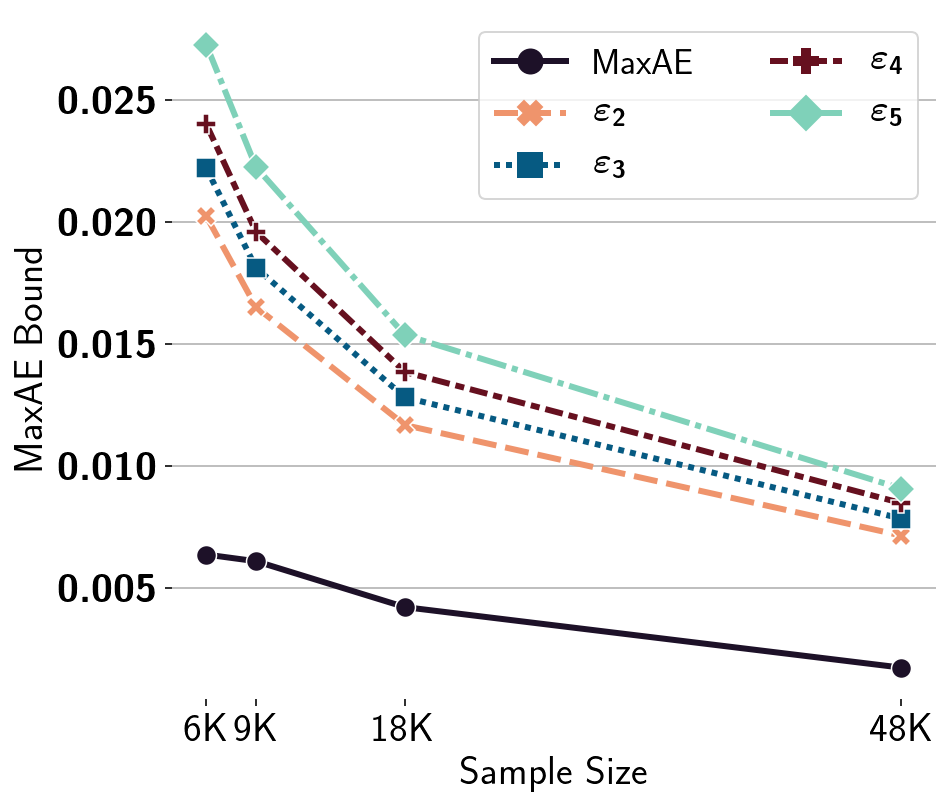

youtube.lg 0.08


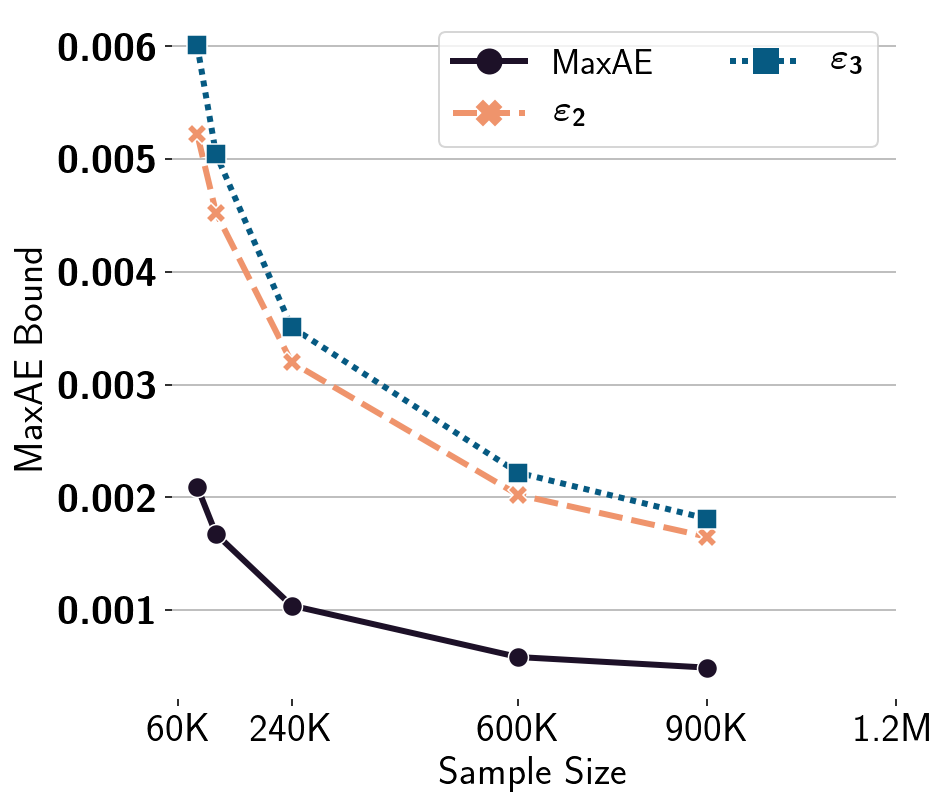

citeseer.lg 0.08


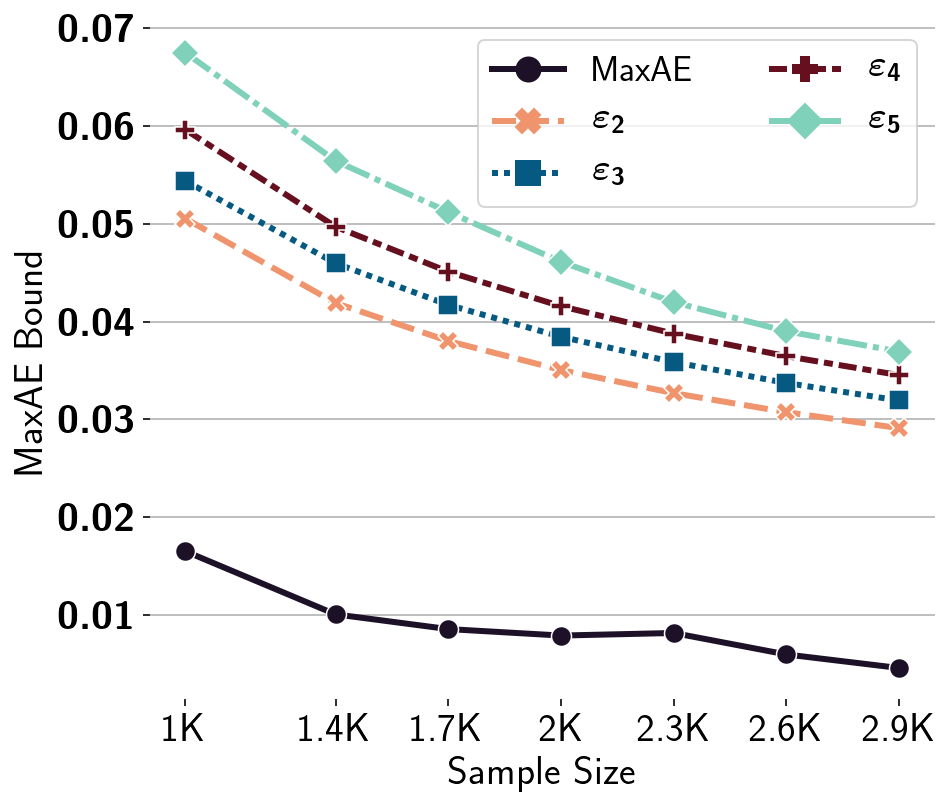

phy_citations_grouped.lg 0.16


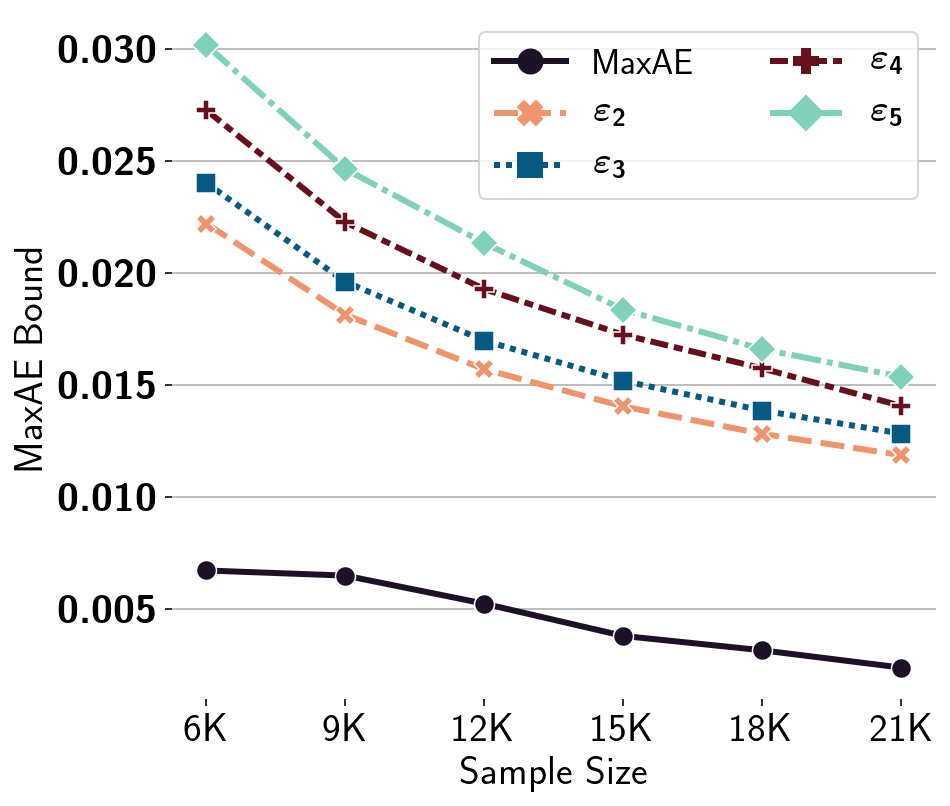

patents_decade.lg 0.16


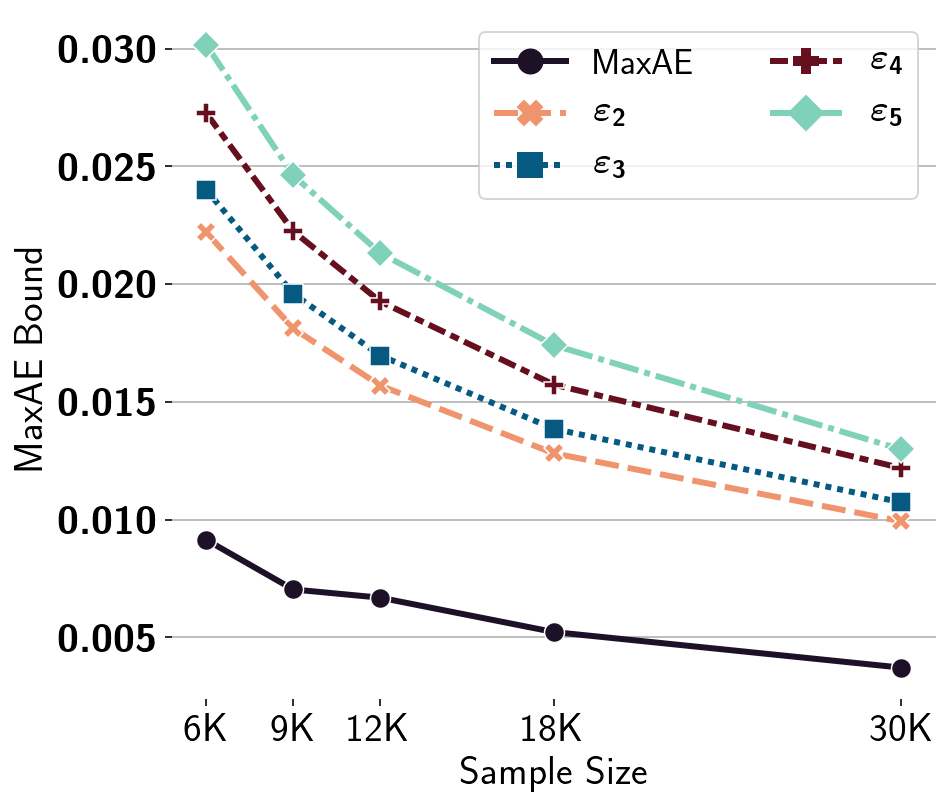

In [683]:
for d in datasets:
    # prepare data
    data = patterns_stats[patterns_stats['dataset']==d][['s','tau', 'MaxAE', 'eps2', 'eps3', 'eps4', 'eps5']]
    idx_max = data[data['s']==sample_sizes_d[d][0]]['MaxAE'].idxmax()
    tau = data.loc[idx_max]['tau']
    if d == 'mico.lg':
        tau = 0.09
    data1 = data[data['tau']==tau].set_index('s')[['MaxAE', 'eps2', 'eps3', 'eps4', 'eps5']]
    data1.rename(columns={'eps2':r'$\varepsilon_2$', 'eps3':r'$\varepsilon_3$', 'eps4':r'$\varepsilon_4$', 'eps5':r'$\varepsilon_5$'}, inplace=True)
    if d == 'youtube.lg':
        data1 = data1[data1.index > 24000][['MaxAE', r'$\varepsilon_2$', r'$\varepsilon_3$']]
        ticks = [60000, 240000, 600000, 900000, 1200000]
        ticksnames = ['60K', '240K', '600K', '900K', '1.2M']
        pal = palette[:-2]
    else:
        ticks = sample_sizes_d[d]
        ticksnames = sample_sizes_d_names[d]
        pal = palette
    print(d,tau)

    plt.figure(figsize=(7,6))
    sns.lineplot(data=data1, palette=pal, linewidth=3, markers=True, markersize=10)
    # style
    plt.xlabel('Sample Size')
    plt.ylabel('MaxAE Bound')
    plt.grid(axis='y')
    plt.xticks(ticks, ticksnames, fontweight='black')
    # legend
    leg = plt.legend(ncol=2)
    for line in leg.get_lines():
        line.set_linewidth(3.0)

    plt.tight_layout()
    plt.savefig(f'epsilons_me_{d}_{taus[0]}.pdf', bbox_inches='tight')
    plt.show()

# Comparison between Online and Offline Strategy

The online strategy creates the pattern space on-the-fly, while the offline strategy loads it from disk 

In [684]:
stats_pregen = pd.read_csv(data_dir + 'statistics_pregen.csv', sep='\t', header=None, names=['dataset','timestamp', 'time', 'freq_patterns', 'tau', 'max_size', 'is_pregenerated', 'sample_size', 'seed'])
stats_pregen.drop(['timestamp', 'seed', 'max_size'], axis=1, inplace=True)
stats_pregen = stats_pregen.groupby(by=['dataset','is_pregenerated', 'sample_size', 'tau']).mean().reset_index()

/Users/giulia/.pyenv/versions/3.7.2/envs/notebook_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/giulia/.pyenv/versions/3.7.2/envs/notebook_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


patents_decade.lg


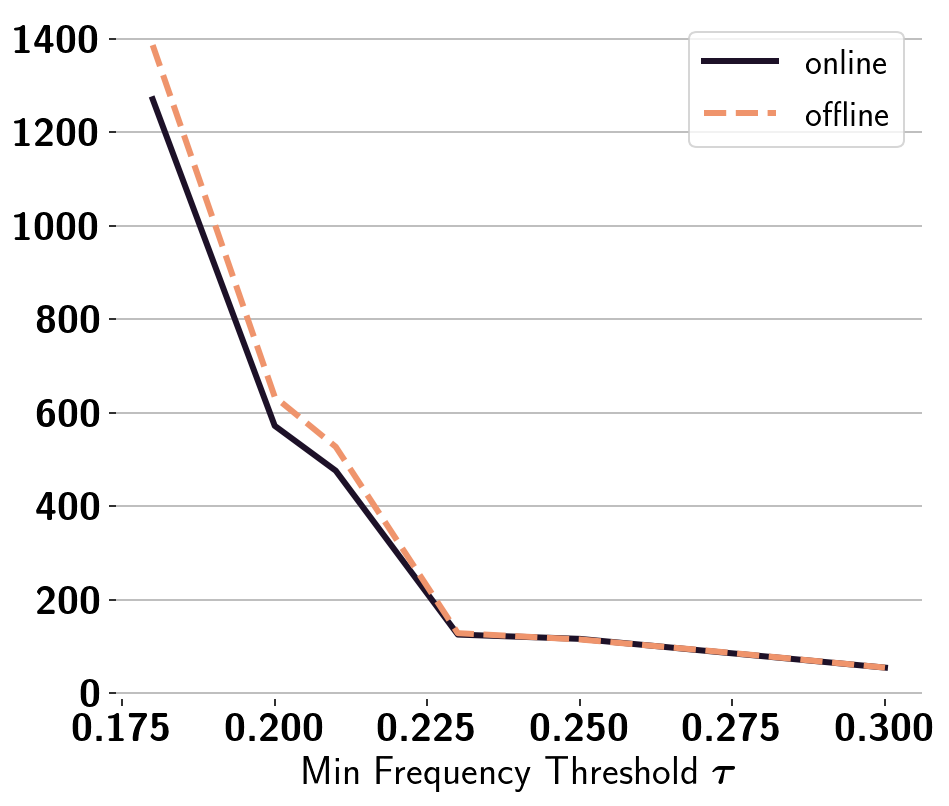

/Users/giulia/.pyenv/versions/3.7.2/envs/notebook_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/giulia/.pyenv/versions/3.7.2/envs/notebook_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


phy_citations_grouped.lg


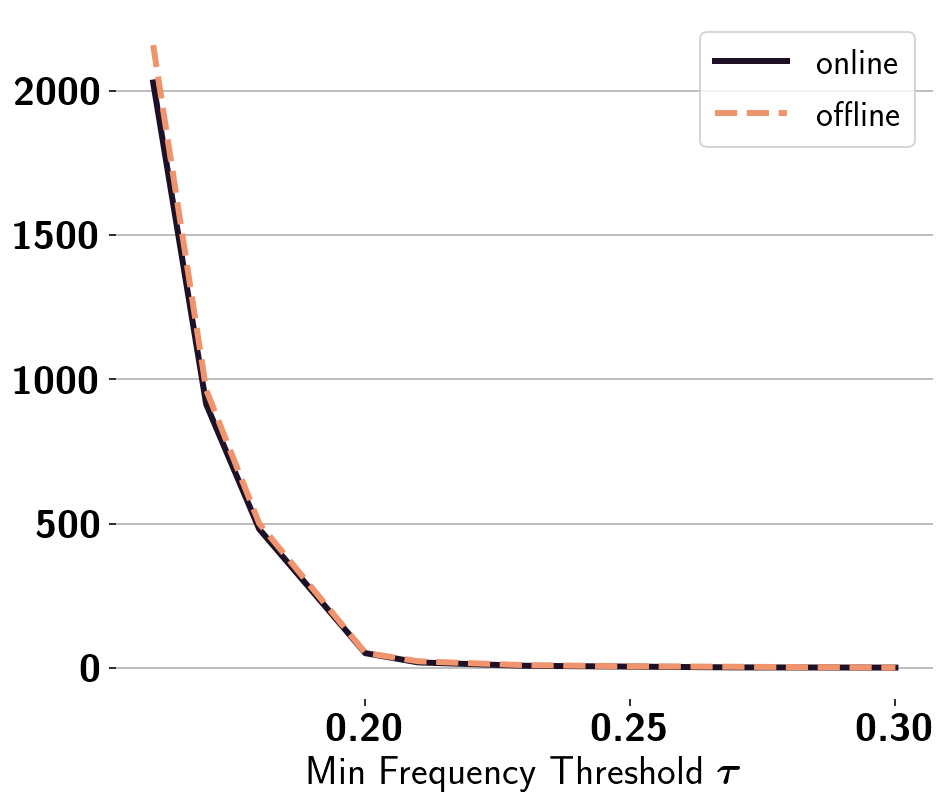

In [685]:
for d in stats_pregen['dataset'].unique():
    
    plt.figure(figsize=(7,6))
    sns.lineplot(data=stats_pregen[stats_pregen['is_pregenerated']==False][stats_pregen['dataset']==d].set_index('tau')['time'], color=palette[0], linewidth=3, label='online')
    sns.lineplot(data=stats_pregen[stats_pregen['is_pregenerated']==True][stats_pregen['dataset']==d].set_index('tau')['time'], color=palette[1], linewidth=3, label='offline')
    # style
    plt.xlabel(r'Min Frequency Threshold $\tau$')
    plt.gca().lines[1].set_linestyle("--")
    plt.grid(axis='y')
    # legend
    for line in plt.legend().get_lines():
        line.set_linewidth(3.0)

    plt.tight_layout()
    plt.savefig(f'pregeneration_{d}.pdf', bbox_inches='tight')
    print(d)
    plt.show()

# Scalability

## Exact

In [686]:
tmp = stats_ex_d[datasets[0]].set_index('tau')[['time']]
tmp.rename(columns={'time':datasets[0]}, inplace=True)
for d in datasets[1:]:
    tmp[d] = stats_ex_d[d].set_index('tau')[['time']]
labels = {'mico.lg':'Mico', 'citeseer.lg':'Citeseer', 'phy_citations_grouped.lg':'Phy-Cit', 'patents_decade.lg':'Patents', 'youtube.lg': 'YouTube'}

### Running Time

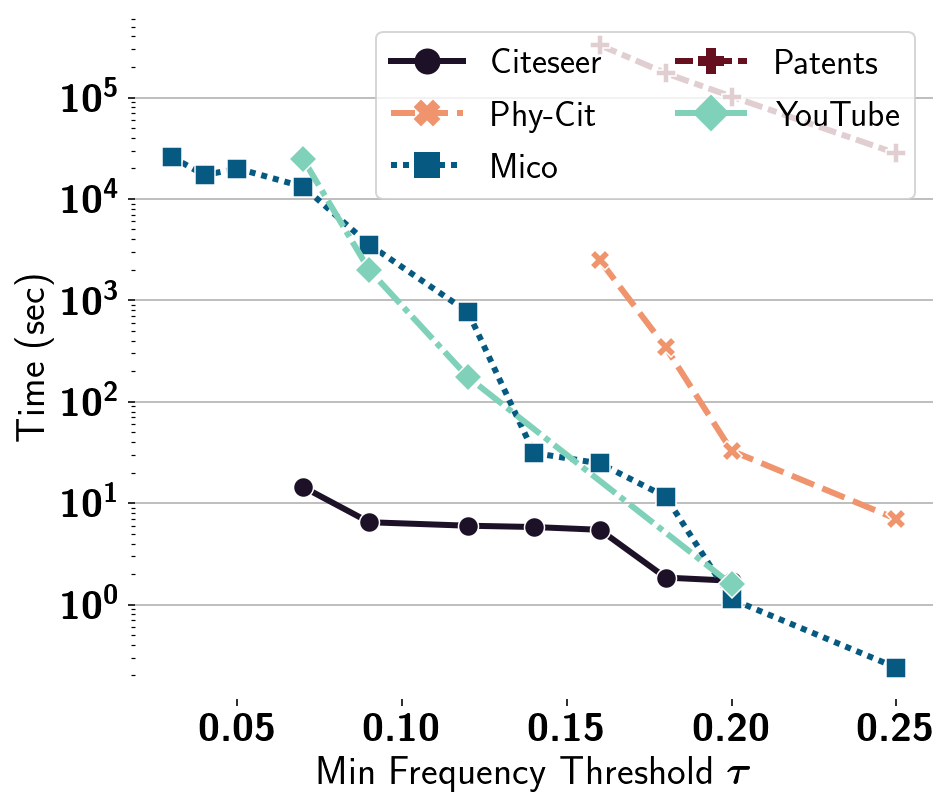

In [687]:
plt.figure(figsize=(7,6))

# prepare data
data = tmp[['citeseer.lg', 'phy_citations_grouped.lg', 'mico.lg', 'patents_decade.lg', 'youtube.lg']]
data.rename(columns=labels, inplace=True)
# plot
sns.lineplot(data=data, palette=palette, linewidth=3, markers=True, markersize=10)
# style
plt.grid(axis='y')
plt.yscale('log')
plt.xlabel(r'Min Frequency Threshold $\tau$')
plt.ylabel('Time (sec)')
# legend
for line in plt.legend(ncol=2).get_lines():
    line.set_linewidth(3.0)

plt.tight_layout()
plt.savefig(f'scalability.pdf', bbox_inches='tight')
plt.show()

### Patterns Found

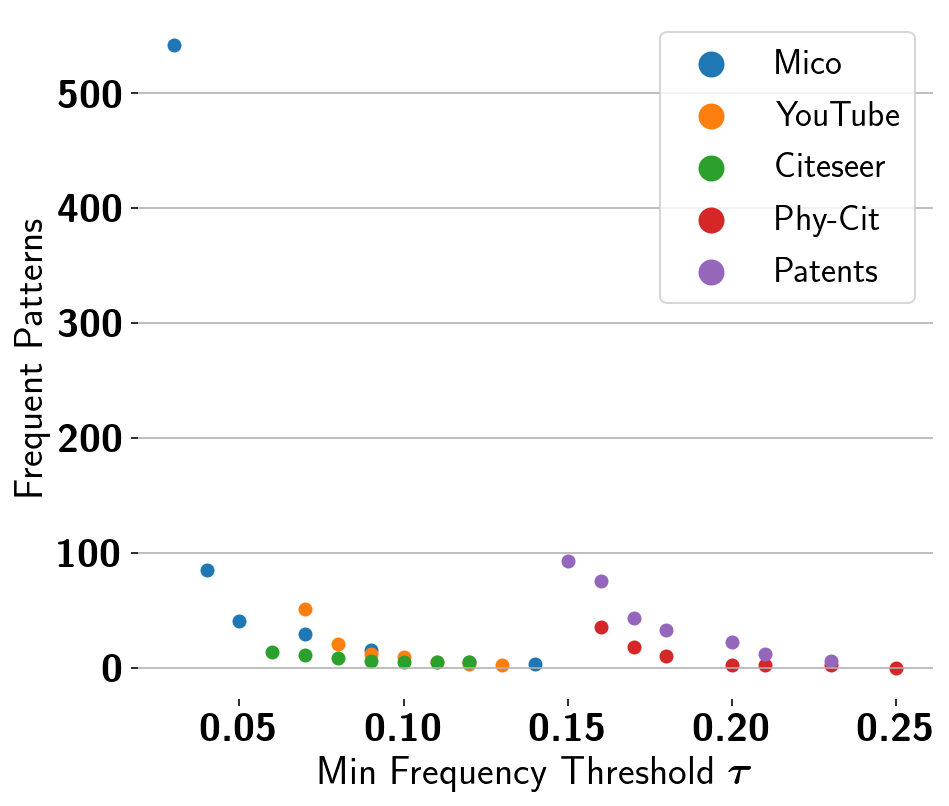

In [688]:
plt.figure(figsize=(7,6))

for d in datasets:
    plt.scatter(stats_ex_d[d]['tau'][:7], stats_ex_d[d]['freq_patterns'][:7], label=labels[d])
# style
plt.xlabel(r'Min Frequency Threshold $\tau$')
plt.ylabel('Frequent Patterns')
plt.grid(axis='y')
# legend
for line in plt.legend().get_lines():
    line.set_linewidth(3.0)

plt.tight_layout()
plt.savefig(f'frequent_patterns.pdf', bbox_inches='tight')
plt.show()

## Approximate

Prepare Data

In [689]:
first = stats_d['mico.lg'][stats_d['mico.lg']['sample_size']==9000].set_index('tau')[['time']]
first.rename(columns={'time': 'Mico-9K'}, inplace=True)
second = stats_d['phy_citations_grouped.lg'][stats_d['phy_citations_grouped.lg']['sample_size']==9000].set_index('tau')[['time']]
second.rename(columns={'time': 'Phy-Cit-9K'}, inplace=True)
first = first.merge(second, how='outer', left_index=True, right_index=True)
second = stats_d['patents_decade.lg'][stats_d['patents_decade.lg']['sample_size']==9000].set_index('tau')[['time']]
second.rename(columns={'time': 'Patents-9K'}, inplace=True)
first = first.merge(second, how='outer', left_index=True, right_index=True)
first

,Mico-9K,Phy-Cit-9K,Patents-9K
tau,,,
0.07,2400.5442,NaN,NaN
0.09,1970.0212,NaN,NaN
0.12,346.5760,NaN,NaN
0.14,72.0476,NaN,NaN
0.16,3.9092,3179.0906,2986.762000
0.17,NaN,1407.8710,2062.737750
0.18,3.0964,745.3356,1697.960125
0.20,1.3586,74.6570,779.418500
0.21,NaN,31.1416,602.110625


Plot

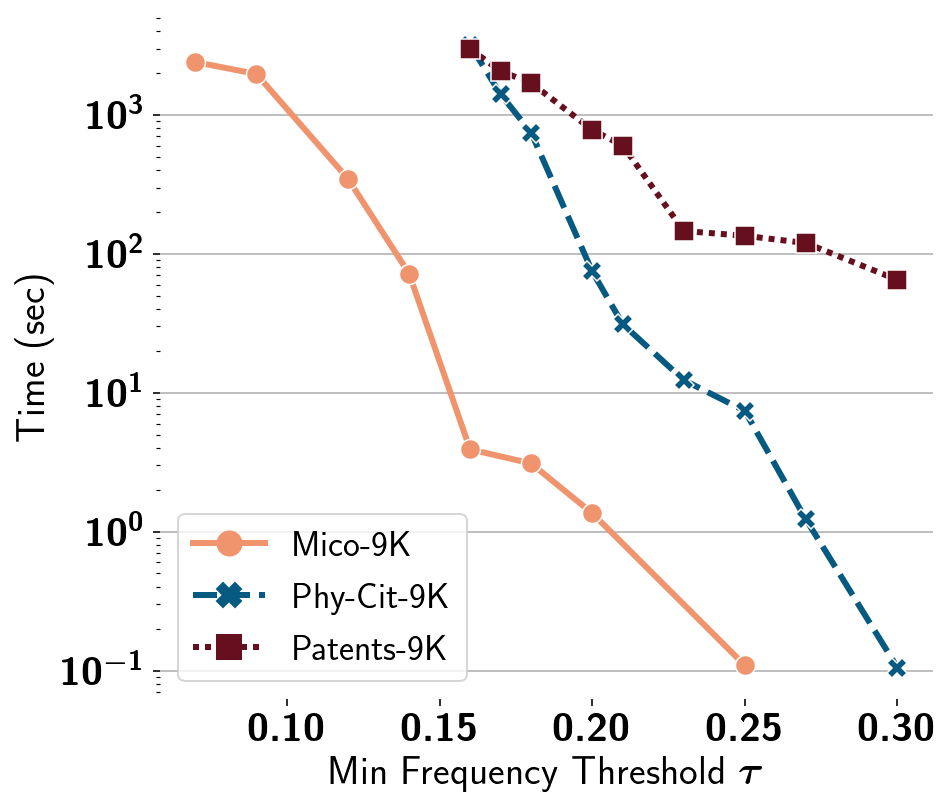

In [690]:
plt.figure(figsize=(7,6))
sns.lineplot(data=first, palette=palette[1:4], linewidth=3, markers=True, markersize=10)
# style
plt.yscale('log')
plt.grid(axis='y')
plt.ylabel('Time (sec)')
plt.xlabel(r'Min Frequency Threshold $\tau$')
# legend
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(3.0)

plt.tight_layout()
plt.savefig(f'scalability_ax.pdf', bbox_inches='tight')
plt.show()

## Plot EX and AX together

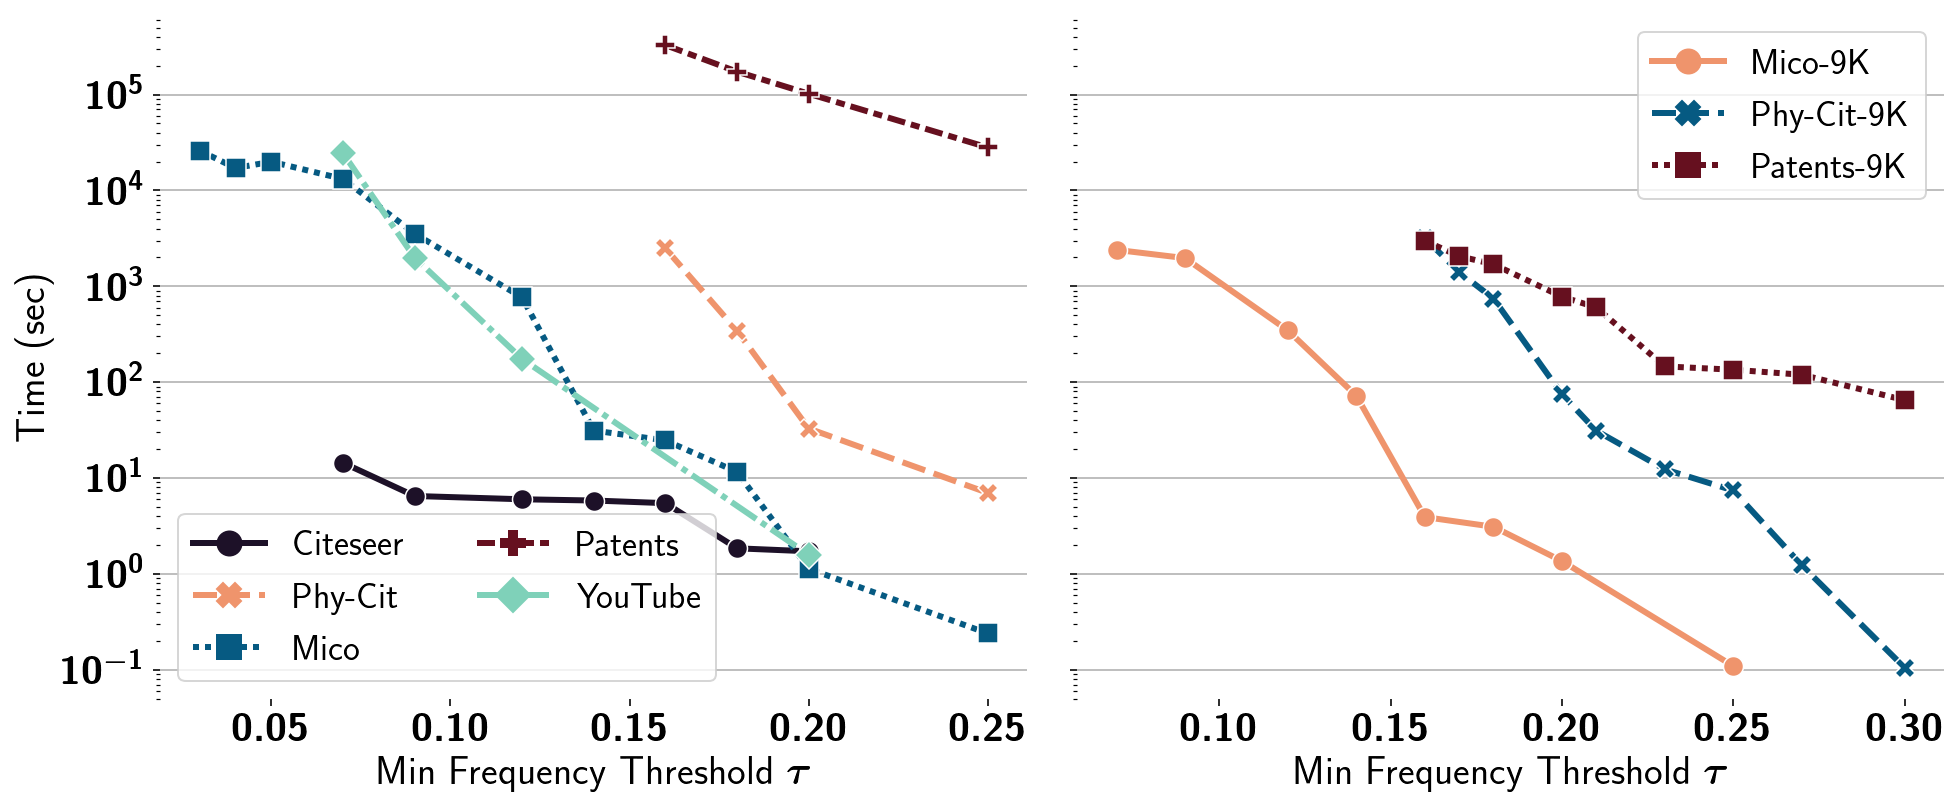

In [691]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6), sharey=True)
# prepare data
data = tmp[['citeseer.lg', 'phy_citations_grouped.lg', 'mico.lg', 'patents_decade.lg', 'youtube.lg']]
data.rename(columns=labels, inplace=True)
# plot
sns.lineplot(data=data, palette=palette, linewidth=3, ax=ax1, markers=True, markersize=10)
sns.lineplot(data=first, palette=palette[1:4], linewidth=3, ax=ax2, markers=True, markersize=10)
# style
ax1.grid(axis='y')
ax2.grid(axis='y')
ax1.set_yscale('log')
ax1.set_xlabel(r'Min Frequency Threshold $\tau$')
ax2.set_xlabel(r'Min Frequency Threshold $\tau$')
ax1.set_ylabel('Time (sec)')
# legend
for line in ax1.legend(ncol=2).get_lines():
    line.set_linewidth(3.0)
for line in ax2.legend().get_lines():
    line.set_linewidth(3.0)

plt.tight_layout()
plt.savefig(f'scalability_all.pdf', bbox_inches='tight')
plt.show()
